# 1. Import Data  

Given: Tabular 

Wanted: ACC report

## Function

In [2]:
# Assuming 'df' is the DataFrame with a column 'Site_number'
# We want to keep only those Site_numbers with a count >= 300, and from those, only keep 300 rows per Site_number

def equal_site(df):
        # Step 1: Filter Site_numbers with count >= 300
    site_counts = df['Site_number'].value_counts()
    sites_to_keep = site_counts[site_counts >= 300].index.tolist()
    
    filtered_df = df[df['Site_number'].isin(sites_to_keep)]
    
    # Step 2: For each Site_number, keep only the first 300 rows
    # This can be done using groupby and head
    new_df = filtered_df.groupby('Site_number').head(300)
    
    # 'new_df' is now the DataFrame that meets the specified criteria
    #new_df.info()  # Displaying the info of new_df to check the result
    return new_df

def aggregatedf_day(df):
    import pandas as pd
    import numpy as np
 
    # Set 'time' to day precision (removing time of day)
    df['time'] = pd.to_datetime(df['time']).dt.floor('D')
    
    # Select only numeric columns (excluding 'Site_number' and 'time' for grouping)
    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()+["time"]
    # Group by 'Site_number' and 'time' (day precision), then calculate the mean of numeric columns
    df = df[numeric_cols].groupby(['Site_number', 'time']).mean().reset_index()
    return df


## 1.2 Data Process

In [30]:
save_dir = r'C:\Users\isxzl\OneDrive\Code\AutoGeo\weight'
grib_fea_path=r"C:\Datasets\Zhejiang20-23RS\ERA5_featureRanking1\2022_Jan_2_Mar_feature.nc"
fealist_pkl=r"C:\Datasets\Zhejiang20-23RS\ERA5_featureRanking1\2022_Jan_2_Mar_feaList.pkl"  
site_Feature_clean_pkl= r'C:\Datasets\Zhejiang20-23RS\ERA5_featureRanking1\site_withCoor_withFea_cleaned.pkl'
site_Feature_clean_pkl= r'C:\Datasets\Zhejiang20-23RS\ERA5_featureRanking1\pseudosite_withCoor_withFea_cleaned.pkl'
selected_feature_num=25
customized_fea=['time','longitude','latitude'] #
label="Negative_oxygen_ions"  #df[['Negative_oxygen_ions']]

In [36]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV, KFold
from feature_engine.imputation import MeanMedianImputer
from feature_engine.outliers import Winsorizer
from feature_engine.datetime import DatetimeFeatures
from feature_engine.wrappers import SklearnTransformerWrapper
from lightgbm import LGBMRegressor 
import pandas as pd
import joblib
import sys
sys.path.append("C:/Users/isxzl/OneDrive/Code/FeatureInsight")
sys.path.append("C:/Users/isxzl/OneDrive/Code/AutoGeo")
from sample.dataset import split_test_train 
from sample.tabular import regression_evaluation_report
from FeatureInsight import struct_Investigation,univar_dis,bivar_dis,clean_ds
import os 


fea = pd.read_pickle(fealist_pkl)
df = pd.read_pickle(site_Feature_clean_pkl) #to load 123.pkl back to the dataframe df

#df=df[df["Site_name"]=="龙游气象站"]

features=fea[:selected_feature_num] + customized_fea
df=clean_ds(df)
#df=equal_site(df)
X = df[features] # ,'height'
y = df[[label]]



t1=MeanMedianImputer(imputation_method='median').fit(X)
X=t1.transform(X)
t2=DatetimeFeatures(variables=["time"],features_to_extract = ["month", "day_of_month","hour"],drop_original=True).fit(X)
X=t2.transform(X)
t3=SklearnTransformerWrapper(StandardScaler(),variables=list(X.columns)).fit(X)
X=t3.transform(X)

tt1=MeanMedianImputer(imputation_method='median').fit(y)
y=tt1.transform(y)
tt2=Winsorizer(variables=[label],capping_method='mad', tail='both', fold=7).fit(y)
y=tt2.transform(y)
tt3=SklearnTransformerWrapper(StandardScaler(),variables=list(y.columns)).fit(y)
#y=tt3.transform(y)

 
# Assuming df is already defined, call the function
_,_,train_ind, test_ind,df= split_test_train(df, split=0.05, flag="Sample",seed=4,pseudo=True)
#_,_,train_ind, test_ind,df= split_test_train(df, split=0.1, flag="Site",seed=1,pseudo=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=5)
X_train, X_test, y_train, y_test = X.loc[train_ind], X.loc[test_ind], y.loc[train_ind], y.loc[test_ind]
#X_train, X_test, y_train, y_test =  

  
# Check if the directory exists, if not, create it
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
 
# Save the model, transformers, and feature list 
joblib.dump(t1, os.path.join(save_dir, 'transformer_t1.pkl'))
joblib.dump(t2, os.path.join(save_dir, 'transformer_t2.pkl'))
joblib.dump(t3, os.path.join(save_dir, 'transformer_t3.pkl'))
joblib.dump(features, os.path.join(save_dir, 'features.pkl'))
# Save the model, transformers, and feature list 
joblib.dump(tt1, os.path.join(save_dir, 'transformer_tt1.pkl'))
joblib.dump(tt2, os.path.join(save_dir, 'transformer_tt2.pkl'))
joblib.dump(tt3, os.path.join(save_dir, 'transformer_tt3.pkl'))

print("Items have been saved successfully.")


Selected Site Count: 59, (98.33%)
Selected DataRow Count: 1279, (5.00%)
Training Site Count: 61, (101.67%)
Training DataRow Count: 39132, (152.91%)
Items have been saved successfully.


## 1.3 Final Model Prediction

[AutoGEO] [Info] Start Analysis the Prediction Accuracy
 Metric         Value
    MAE    283.373534
    MSE 186178.188834
   RMSE    431.483706
    R^2      0.755532
Samples   1279.000000


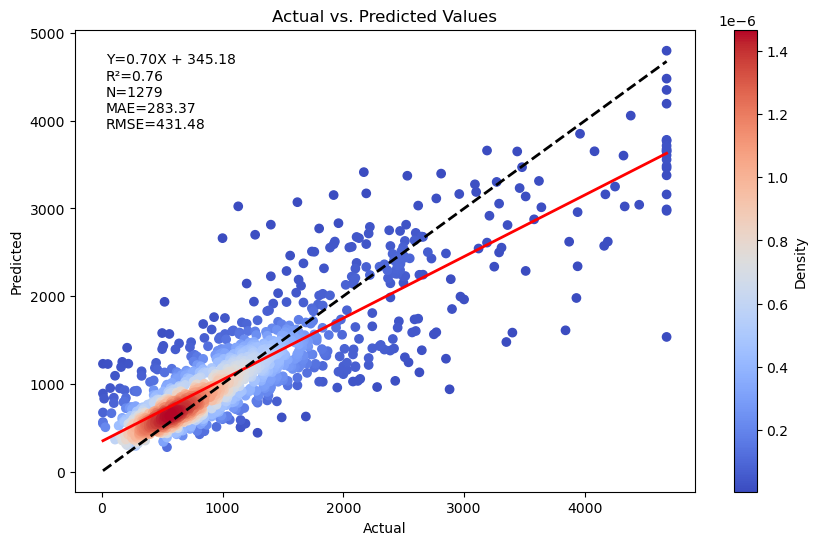

In [37]:
 from lightgbm import LGBMRegressor   
import joblib
import sys
sys.path.append("C:/Users/isxzl/OneDrive/Code/FeatureInsight")
sys.path.append("C:/Users/isxzl/OneDrive/Code/AutoGeo") 
from sample.tabular import regression_evaluation_report 


save_dir = r'C:\Users\isxzl\OneDrive\Code\AutoGeo\weight'
 # 定义模型
model = LGBMRegressor(random_state=42, verbose=-1)
model.fit(X_train, y_train)

joblib.dump(model, os.path.join(save_dir, 'model.pkl'))

y_pred = model.predict(X_test)
metrics_report=regression_evaluation_report(y_test[label], y_pred)

# 2. LGBM

## Function

## Code

LGBMRegressor(max_depth=20, num_leaves=100, random_state=42, verbose=-1)
[AutoGEO] [Info] Start Analysis the Prediction Accuracy
 Metric       Value
    MAE    0.314336
    MSE    0.241879
   RMSE    0.491812
    R^2    0.787001
Samples 1279.000000


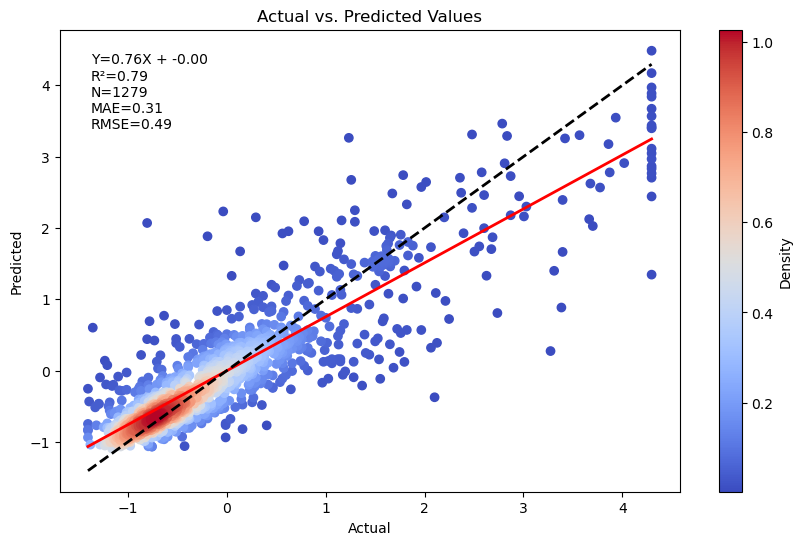

In [12]:
from lightgbm import LGBMRegressor 
from sklearn.model_selection import GridSearchCV, KFold
# 参数网格
param_grid = {
    'num_leaves': [31, 50, 100],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.1, 0.01, 0.05]
}

# 定义模型
model = LGBMRegressor(random_state=42, verbose=-1)
grid_search = GridSearchCV(model, param_grid, cv=KFold(n_splits=5, shuffle=True, random_state=42), scoring='neg_mean_squared_error', verbose=0)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print(best_model) #max_depth=20, num_leaves=100, random_state=42



# 使用最佳模型在测试集上进行预测
y_pred = best_model.predict(X_test)

metrics_report=regression_evaluation_report(y_test['Negative_oxygen_ions'], y_pred)




# 3. XGBoost

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)
[AutoGEO] [Info] Start Analysis the Prediction Accuracy
 Metric       Value
    MAE    0.178118
    MSE    0.103365
   RMSE    0.321505
    R^2    0.903116
Samples 1981.000000


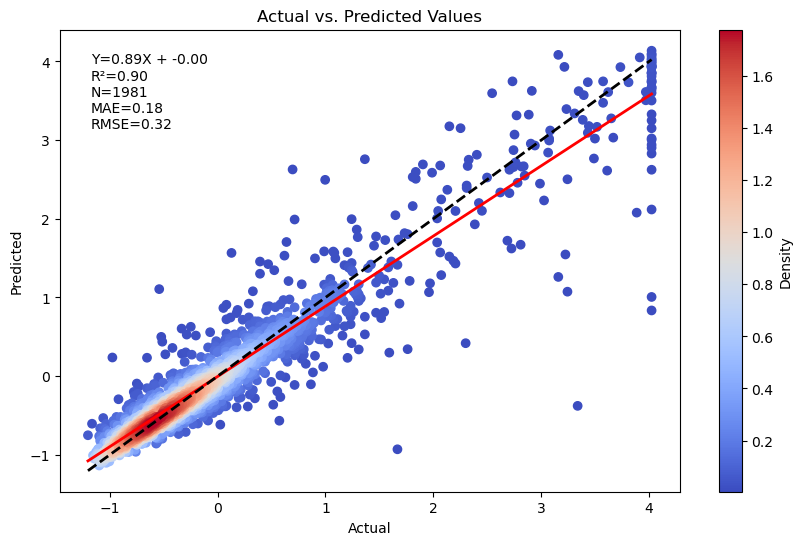

In [10]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, KFold

# 参数网格
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.1, 0.01, 0.05]
}

# 定义模型
model = XGBRegressor(random_state=42)
grid_search = GridSearchCV(model, param_grid, cv=KFold(n_splits=5, shuffle=True, random_state=42), scoring='neg_mean_squared_error', verbose=0)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print(best_model)

# 使用最佳模型在测试集上进行预测
y_pred = best_model.predict(X_test)
metrics_report = regression_evaluation_report(y_test, y_pred)


# 4. MLP

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, KFold

# 参数网格
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['relu', 'tanh'],
    'solver': [ 'sgd'], #'adam',
    'learning_rate_init': [0.001, 0.01]
}

# 定义模型
model = MLPRegressor(random_state=42, max_iter=1000)
grid_search = GridSearchCV(model, param_grid, cv=KFold(n_splits=5, shuffle=True, random_state=42), scoring='neg_mean_squared_error', verbose=0)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print(best_model)

# 使用最佳模型在测试集上进行预测
y_pred = best_model.predict(X_test)
metrics_report = regression_evaluation_report(y_test, y_pred)


C:\Users\isxzl\anaconda3\envs\EO\lib\site-packages\sklearn\neural_network\_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
C:\Users\isxzl\anaconda3\envs\EO\lib\site-packages\sklearn\utils\extmath.py:192: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
C:\Users\isxzl\anaconda3\envs\EO\lib\site-packages\sklearn\utils\extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
C:\Users\isxzl\anaconda3\envs\EO\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\isxzl\anaconda3\envs\EO\lib\site-packages\sklearn\neural_network\_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
C:\Users\isxzl\anaconda3\envs\EO\lib\site-packages\sklearn\utils\extmath.py:192: RuntimeWarning: overflow enco

# 5. Elastic Net

ElasticNet(alpha=0.1, l1_ratio=0.1, max_iter=3000, random_state=42)
[AutoGEO] [Info] Start Analysis the Prediction Accuracy
 Metric       Value
    MAE    0.879726
    MSE    1.074837
   RMSE    1.036743
    R^2   -0.533855
Samples 2718.000000


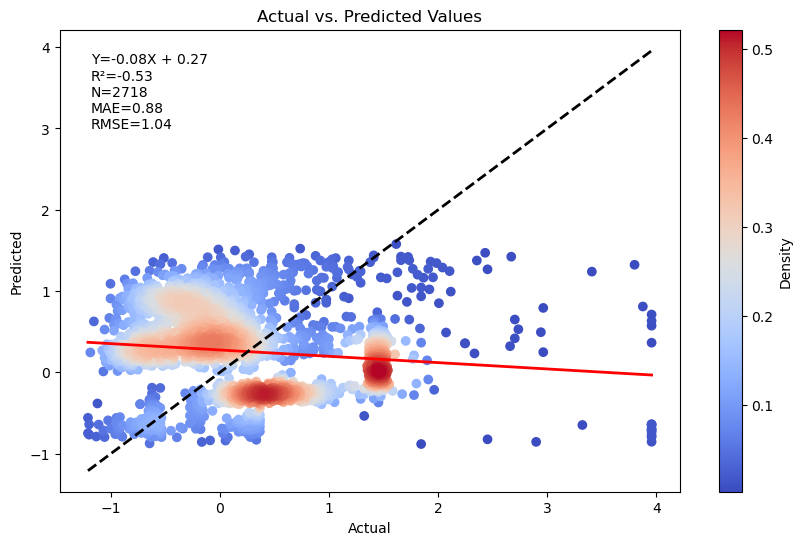

In [42]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV, KFold

# 参数网格
param_grid = {
    'alpha': [0.1, 1.0, 10.0],
    'l1_ratio': [0.1, 0.5, 0.9],
     'max_iter': [3000],
}

# 定义模型
model = ElasticNet(random_state=42)
grid_search = GridSearchCV(model, param_grid, cv=KFold(n_splits=5, shuffle=True, random_state=42), scoring='neg_mean_squared_error', verbose=0)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print(best_model)

# 使用最佳模型在测试集上进行预测
y_pred = best_model.predict(X_test)
metrics_report = regression_evaluation_report(y_test['Negative_oxygen_ions'], y_pred)


# 6. KNN

ElasticNet(alpha=0.1, l1_ratio=0.1, random_state=42)
[AutoGEO] [Info] Start Analysis the Prediction Accuracy
 Metric       Value
    MAE    0.646730
    MSE    0.848549
   RMSE    0.921167
    R^2    0.252764
Samples 1279.000000


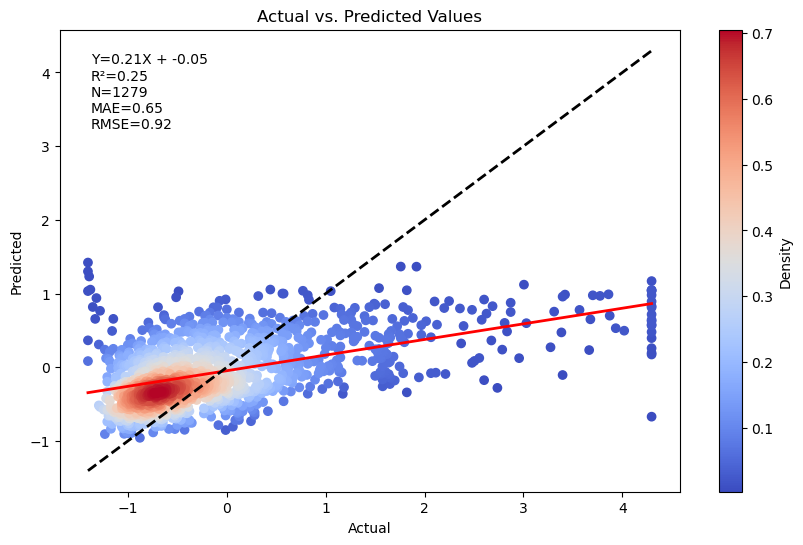

In [23]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV, KFold

# 参数网格
param_grid = {
    'alpha': [0.1, 1.0, 10.0],
    'l1_ratio': [0.1, 0.5, 0.9]
}

# 定义模型
model = ElasticNet(random_state=42)
grid_search = GridSearchCV(model, param_grid, cv=KFold(n_splits=5, shuffle=True, random_state=42), scoring='neg_mean_squared_error', verbose=0)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print(best_model)

# 使用最佳模型在测试集上进行预测
y_pred = best_model.predict(X_test)
metrics_report = regression_evaluation_report(y_test['Negative_oxygen_ions'], y_pred)


# 7. LR

In [25]:
y_pred.shape

(1279,)

[AutoGEO] [Info] Start Analysis the Prediction Accuracy
 Metric       Value
    MAE    0.616227
    MSE    0.796579
   RMSE    0.892513
    R^2    0.298529
Samples 1279.000000


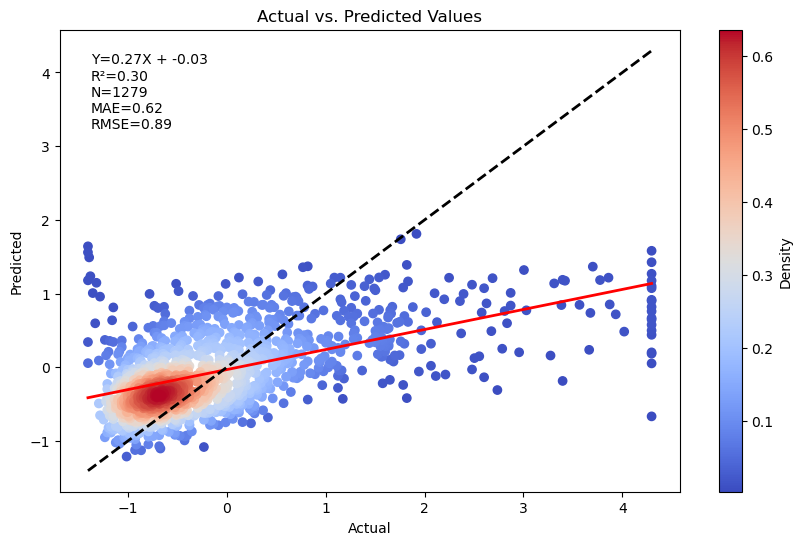

In [29]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import GridSearchCV, KFold
 
# 定义模型
model = LinearRegression() 
model.fit(X_train, y_train) 


# 使用最佳模型在测试集上进行预测
y_pred = model.predict(X_test)

metrics_report=regression_evaluation_report(y_test['Negative_oxygen_ions'], y_pred[:,0])



(1279,)

# 8. RF

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END max_depth=None, min_samples_leaf=2, n_estimators=30; total time=  10.6s
[CV] END max_depth=None, min_samples_leaf=2, n_estimators=30; total time=  10.6s
[CV] END max_depth=None, min_samples_leaf=2, n_estimators=30; total time=  10.7s
[CV] END max_depth=None, min_samples_leaf=2, n_estimators=30; total time=   9.7s
[CV] END max_depth=None, min_samples_leaf=2, n_estimators=30; total time=   9.6s
[CV] END max_depth=None, min_samples_leaf=2, n_estimators=20; total time=   6.3s
[CV] END max_depth=None, min_samples_leaf=2, n_estimators=20; total time=   6.4s
[CV] END max_depth=None, min_samples_leaf=2, n_estimators=20; total time=   6.5s
[CV] END max_depth=None, min_samples_leaf=2, n_estimators=20; total time=   6.3s
[CV] END max_depth=None, min_samples_leaf=2, n_estimators=20; total time=   6.3s
[CV] END max_depth=None, min_samples_leaf=4, n_estimators=30; total time=   8.2s
[CV] END max_depth=None, min_samples_leaf=4, n_es

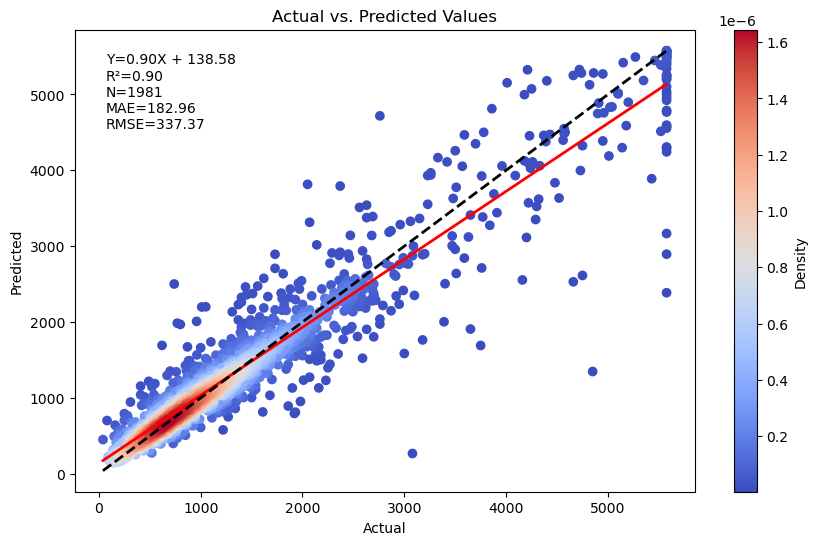

In [33]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold
# 参数网格
# RandomForest
param_grid_random_forest = {
    'n_estimators': [30, 20], 
     'max_depth': [None, 10], #, 20, 30
    # 'min_samples_split': [2, 5, 10],
     'min_samples_leaf': [2, 4]
}

# 定义模型
model = RandomForestRegressor(random_state=42, verbose=0)
grid_search = GridSearchCV(model, param_grid_random_forest, cv=KFold(n_splits=5, shuffle=True, random_state=42), scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print(best_model) #max_depth=20, num_leaves=100, random_state=42

# 使用最佳模型在测试集上进行预测
y_pred = best_model.predict(X_test)
metrics_report=regression_evaluation_report(y_test, y_pred)


